<a href="https://colab.research.google.com/github/ronsegev98/Assignment_1_Group5/blob/main/Assignment_1_Group5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1:

## Ron Segev, Noa Shalom, Dor Avrahami, Yam Almog


In [2]:
#import necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split




In [3]:
#access train from github
train_raw = pd.read_csv('https://raw.githubusercontent.com/ronsegev98/Assignment_1_Group5/main/train.csv')




count is our target (the number of bikes rented) so we'll split the dataframe into two:

In [4]:
#Split into X,Y
X_train_raw = train_raw.drop(['count'], axis=1)
Y_train_raw = train_raw[['count']]

We split the data into training and validation tests in order to have an unbiased dataset for testing our models later.

-----------------------------
# 1. Exploration Phase



Our dataset consists of multiple datatypes. They are as follows:

datetime - time of rental - string

season - categorical

      - 1:winter

      - 2:spring

      - 3:summer

      - 4:fall

holiday - (Is it a bank holiday? If so: 1, else 0) - binary

workingday - (Is it a working day? If so: 1, else 0) - binary

weather - categorical

        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy

        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature - continuous

atemp - average temperature - continuous

humidity - continuous

windspeed - continuous

pollution - continuous

sunlight - continuous

traffic - continuous

count (Label) - continuous

In order to properly assess the given data, we will evaluate each data type separately.

# Continuous Features

### Statistics


Summary stats for each continuous feature


In [5]:
# Selecting only continuous features
continuous_features = train_raw.select_dtypes(include=['float64', 'int64'])

# Columns to exclude from summary statistics
columns_to_exclude = ['season', 'holiday', 'workingday','weather']

# Exclude specified columns
continuous_features = continuous_features.drop(columns=columns_to_exclude, errors='ignore')

# Summary statistics for each continuous feature
summary_stats = continuous_features.describe().transpose().round(2)

# Print the summary statistics table
table = tabulate(summary_stats, headers='keys', tablefmt='pretty')
print("Summary Statistics for each continuous feature:")
print(table)


Summary Statistics for each continuous feature:
+-----------+--------+--------+--------+------+-------+-------+-------+-------+
|           | count  |  mean  |  std   | min  |  25%  |  50%  |  75%  |  max  |
+-----------+--------+--------+--------+------+-------+-------+-------+-------+
|   temp    | 8164.0 | 20.24  |  7.8   | 0.82 | 13.94 | 20.5  | 26.24 | 41.0  |
|   atemp   | 8164.0 | 23.67  |  8.47  | 0.76 | 16.66 | 24.24 | 31.06 | 45.46 |
| humidity  | 8164.0 | 61.84  | 19.26  | 0.0  | 47.0  | 62.0  | 77.0  | 100.0 |
| windspeed | 8164.0 | 12.79  |  8.21  | 0.0  |  7.0  | 13.0  | 17.0  | 57.0  |
| pollution | 8164.0 | 47.15  | 72.88  | 0.0  | 3.69  | 17.68 | 59.26 | 754.3 |
| sunlight  | 8164.0 | 20.25  |  7.8   | 0.82 | 13.94 | 20.5  | 26.24 | 41.0  |
|  traffic  | 8164.0 |  0.0   |  0.01  | 0.0  |  0.0  |  0.0  |  0.0  | 0.02  |
|   count   | 8164.0 | 191.34 | 181.14 | 1.0  | 41.0  | 145.0 | 285.0 | 970.0 |
+-----------+--------+--------+--------+------+-------+-------+-------+-

These statistics provide a comprehensive overview of the distribution and variability of each continuous feature in the dataset. Further analysis, such as correlation studies and visualization, can help uncover relationships and patterns between these features and the bike rental counts.








## Distribution of Continuous Features

We will check  distribution of continuous variables in order to see which statistical methods we can use in preprocessing, as some require normal distribution.

In [6]:
# list of continuous columns
continuous_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'pollution', 'sunlight', 'traffic']

# Initialize an empty list to store the results
results = []

# Iterate over each continuous column
for column in continuous_columns:
    # Make a copy of the column data and remove missing values
    data = train_raw[column].copy().dropna()

    # Perform Kolmogorov-Smirnov test
    stat, p = stats.kstest(data, 'norm', alternative='two-sided')
    results.append([column, stat, p])

# Display results in a table
headers = ["Column", "K-S Statistic", "p-value"]
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt='pretty'))


+-----------+--------------------+---------+
|  Column   |   K-S Statistic    | p-value |
+-----------+--------------------+---------+
|   temp    | 0.9983785637828636 |   0.0   |
|   atemp   | 0.998209830693731  |   0.0   |
| humidity  | 0.9981626653601176 |   0.0   |
| windspeed | 0.877511023040509  |   0.0   |
| pollution | 0.7980655764419594 |   0.0   |
| sunlight  | 0.9983804004948836 |   0.0   |
|  traffic  |        0.5         |   0.0   |
+-----------+--------------------+---------+


The code calculates the Kolmogorov-Smirnov for each continuous column in the raw dataset. The test compares the distribution of each column against a normal distribution. The test statistic (K-S statistic) measures the maximum difference between the cumulative distribution function (CDF) of the data and the CDF of the normal distribution.

The results are displayed in a table, including the column name, K-S statistic, and p-value. The K-S statistic represents the maximum distance between the empirical distribution function of the data and the theoretical distribution (in this case, the normal distribution). The p-value indicates the probability of observing a K-S statistic as extreme as the one obtained under the null hypothesis (the data follows a normal distribution).

**Interpreting the results:**

For the "temp" column, the K-S statistic is 0.998, indicating a significant difference between the distribution of the data and a normal distribution. The p-value is 0.0, suggesting strong evidence against the data following a normal distribution.
The same pattern applies to other columns like "atemp", "humidity", "windspeed","pollution", "sunlight". Regarding "traffic", the K-S statistic is 0.5, which indicates a moderate discrepancy between the empirical distribution of traffic data and a uniform distribution. The low p-value supports rejecting the null hypothesis.

In summary, based on the K-S statistics and p-values obtained from the Kolmogorov-Smirnov test, it can be concluded that the distribution of the data in these columns significantly deviates from a normal distribution. The low p-values suggest that these columns are not normally distributed and have different characteristics.

## **We can see this further graphically**

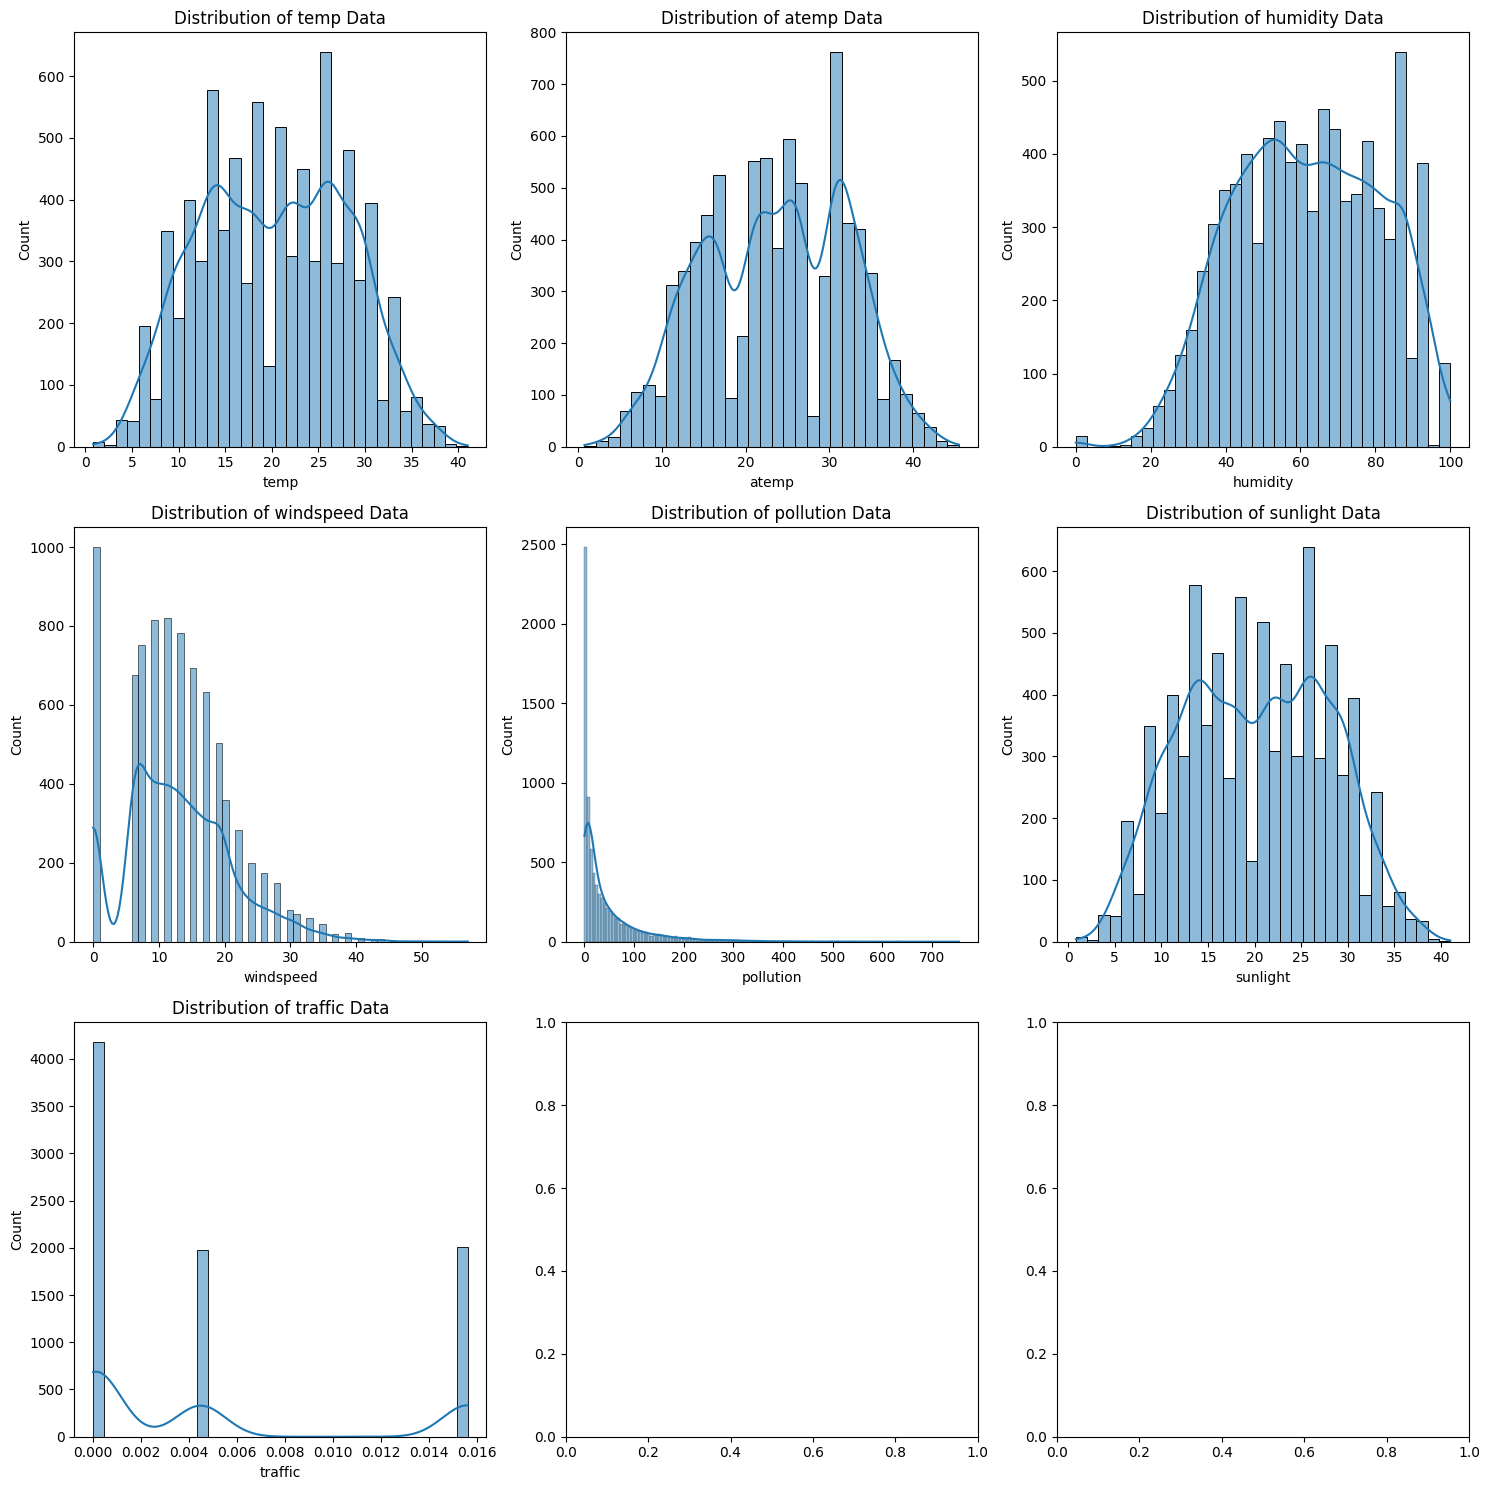

In [7]:

#need to make this only continuous features

def selected_feature_dist(df, features):
    # Create subplots based on the number of selected features
    num_rows = (len(features) - 1) // 3 + 1
    num_cols = min(len(features), 3)

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    # Plot the distribution for each selected feature
    for i, feature in enumerate(features):
        sns.histplot(df[feature], kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {feature} Data")

    # Tight layout to avoid overlapping
    plt.tight_layout()
    plt.show()




selected_feature_dist(train_raw, continuous_columns)

In [8]:
def show_feature_dist(df, feature):
    plt.figure(figsize=(3,3))
    grouped_counts = df.groupby(feature)['count'].sum().reset_index(name='Total_Count')

    fig = px.bar(grouped_counts, x=feature, y='Total_Count', color='Total_Count',
                labels={feature: feature, 'Total_Count': 'Total Count'},
                title=f'Total Count of bikes rented for each {feature}')

    fig.show()

categorical_feature_list = ['season', 'weather']

for feature in categorical_feature_list:
    show_feature_dist(train_raw,feature)


<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

#EXPLANATION OF THESE GRAPHS!!!!

In [9]:
binary_feature_list = ['holiday', 'workingday']

for feature in binary_feature_list:
    show_feature_dist(train_raw,feature)

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

#EXPLANATION OF THESE GRAPHS!!!!

In [10]:
# def show_temperature_dist(df):
#     plt.figure(figsize=(3,3))

#     # Create temperature groups
#     temperature_bins = list(range(0, 41, 5))
#     temperature_labels = [f'{i}-{i+5}' for i in range(0, 40, 5)]
#     df['temperature_group'] = pd.cut(df['temp'], bins=temperature_bins, labels=temperature_labels, right=False)

#     grouped_counts = df.groupby('temperature_group')['count'].sum().reset_index(name='Total_Count')

#     fig = px.bar(grouped_counts, x='temperature_group', y='Total_Count', color='Total_Count',
#                 labels={'temperature_group': 'Temperature Group', 'Total_Count': 'Total Count'},
#                 title='Total Count of bikes rented for each Temperature Group')

#     fig.show()

# show_temperature_dist(train_raw)


def show_temperature_dist(df):
    plt.figure(figsize=(3,3))

    # Create temperature groups
    temperature_bins = list(range(0, 41, 5))
    temperature_labels = [f'{i}-{i+5}' for i in range(0, 40, 5)]

    grouped_counts = df.groupby(pd.cut(df['temp'], bins=temperature_bins, labels=temperature_labels, right=False))['count'].sum().reset_index(name='Total_Count')

    fig = px.bar(grouped_counts, x='temp', y='Total_Count', color='Total_Count',
                labels={'temp': 'Temperature Group', 'Total_Count': 'Total Count'},
                title='Total Count of bikes rented for each Temperature Group')

    fig.update_xaxes(categoryorder='array', categoryarray=temperature_labels)  # To order x-axis categories
    fig.show()

show_temperature_dist(train_raw)



<Figure size 300x300 with 0 Axes>

#EXPLANATION OF THESE GRAPHS!!!!

## Datetime Hours Histogram


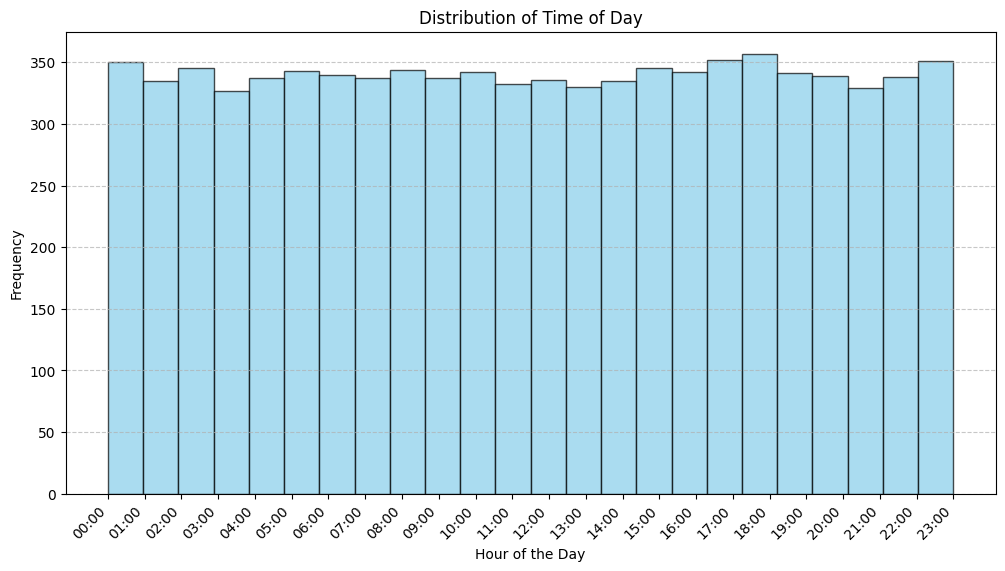

In [11]:

X_train_raw['datetime'] = pd.to_datetime(X_train_raw['datetime'], format='%Y-%m-%d %H:%M:%S')

# Create a new column for the time of day
X_train_raw['time_of_day'] = X_train_raw['datetime'].dt.hour


# Create a histogram
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.hist(X_train_raw['time_of_day'], bins=24, color='skyblue', edgecolor='black', alpha=0.7, align='mid')  # Set align to 'mid'

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Distribution of Time of Day')

# Customize x-axis ticks for better readability
plt.xticks(range(0, 24), [f'{hour:02d}:00' for hour in range(0, 24)])
# Customize x-axis ticks for better readability
plt.xticks(rotation=45, ha='right')  # R

# Display the plot
plt.show()

X_train_raw = X_train_raw.drop('time_of_day',axis=1)




As can be seen by the Histogram, the time of day affects the amount of bikes rented. Therefore, we will use this column as a feature later in our models.

### Plot by Months

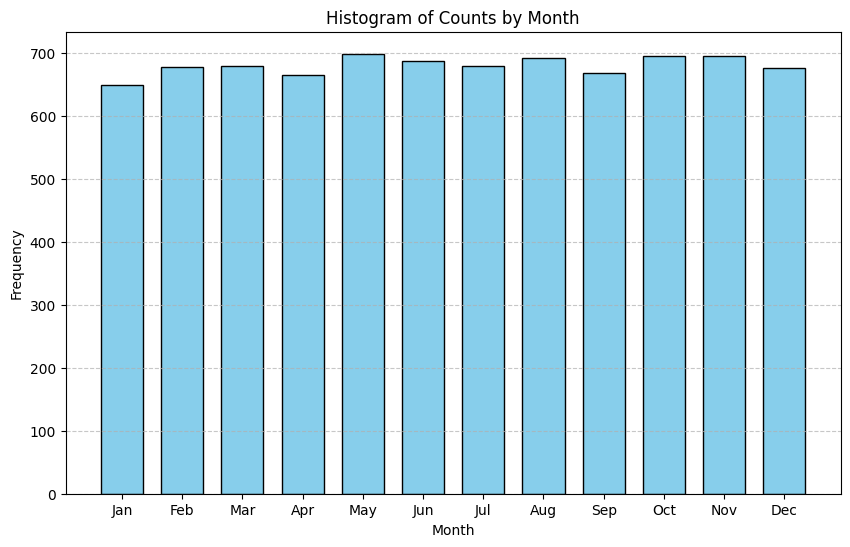

In [12]:
# Assuming df is your DataFrame with the 'datetime' column
X_train_raw['datetime'] = pd.to_datetime(X_train_raw['datetime'], format='%Y-%m-%d %H:%M:%S')

# Create a new column for the month
X_train_raw['month'] = X_train_raw['datetime'].dt.month

# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(X_train_raw['month'], bins=range(1, 14), color='skyblue', edgecolor='black', align='left', rwidth=0.7)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylabel('Frequency')
plt.title('Histogram of Counts by Month')
plt.xlabel('Month')

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

plt.show()

X_train_raw = X_train_raw.drop('month',axis=1)


As seen here, there are certain months that rentals are much more frequent. This makes sense as months with weather that is perfect for biking (such as May) has the highest amount of rentals.

In [13]:
def print_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]

    if missing_values.empty:
        print("No missing values in the dataset.")
    else:
        print("Number of missing values in each feature:")
        print(missing_values)

# Assuming train_raw is your DataFrame
missing_values = train_raw.isnull().sum()
print(missing_values)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
pollution     0
sunlight      0
traffic       0
count         0
dtype: int64


## explain why missing values is important, show that we have none

## Correlation


For our first basic exploration of this dataset, we want to analyze correlation between features (and the label)


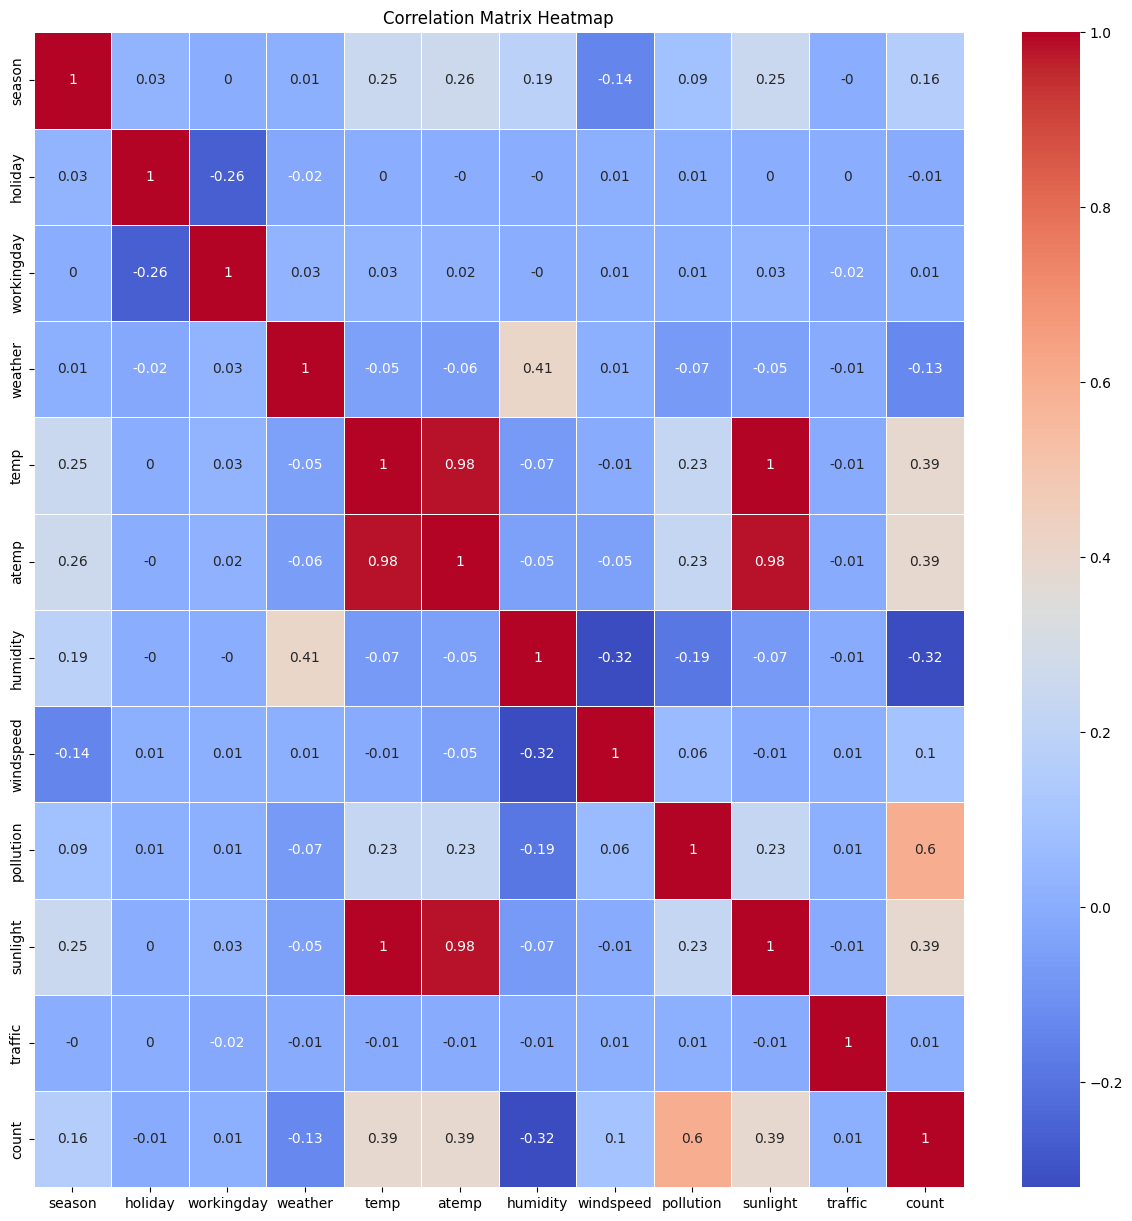

In [14]:
# Correlation matrix heatmap
correlation_matrix = train_raw.corr(numeric_only=True).round(2)
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

removing atemp or temp
removing *sunlight*




Features for one-hot

Season, weather

give explanation why

#Preprocessing

We split the data into training and validation tests in order to have an unbiased dataset for testing our models later.

In [15]:
# Split the data into train and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_train_raw,Y_train_raw,test_size = 0.2, random_state = 42)


### Dealing with Datetime

This feature is arguibluy the most important and needs special attenton due to its nature. The format in which datetime is given is not of one type therefore we need to extract all relevant data to properly assess the effects of the time and date in which bikes were rented.

As explained in the hours histogram, we use created an 'hours' column in order to factor the effect of the hour of the day on rentals.

In addition, using trigonometric functions like sine or cosine on time features is a common technique in time series analysis and machine learning when dealing with cyclical patterns, such as daily or yearly cycles. The idea is to represent the time of day as a cyclic feature rather than a linear one.

If we create an hourly time feature, this helps the model understand the cyclical nature of time, preventing it from interpreting 23:00 and 00:00, for instance, as being far apart.

Lastly, we created a 'month' column in order to include the effect different months of the year have on bike rentals (as seen in the histogram beforehand).

In [16]:
# def time_of_day(df):
#   # Assuming 'daytime' is a column in your DataFrame
#   df['datetime'] = pd.to_datetime(df['datetime'])


#   # Create a new feature indicating the time of the day
#   df['time_of_day'] = pd.cut(df['datetime'].dt.hour,
#                             bins=[-1, 5, 11, 17, 22],
#                             labels=['Night', 'Morning', 'Noon', 'Evening'],
#                             include_lowest=True)




#   # Assuming your dataframe is named 'df' and 'datetime' column is in datetime format
#   df['datetime'] = pd.to_datetime(df['datetime'])


#   # Create the new features
#   df['hour'] = df['datetime'].dt.hour
#   df['morning'] = ((df['hour'] >= 5) & (df['hour'] < 12)).astype(int)
#   df['noon'] = ((df['hour'] >= 12) & (df['hour'] < 18)).astype(int)

#   df['evening'] = ((df['hour'] >= 18) & (df['hour'] < 23)).astype(int)
#   df['night'] = ((df['hour'] >= 23) | (df['hour'] < 5)).astype(int)


#   # Drop the 'hour' column if you no longer need it
#   #
#   #df = df.drop('hour',axis=1)
#   df = df.drop('time_of_day',axis=1)
#   # Display the updated DataFrame
#   return df

# X_train = time_of_day(X_train)
# X_train


In [17]:
def datetime(df):
    # Assuming df is your DataFrame with the 'datetime' column
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

    # Create a new column for the month
    df['month'] = df['datetime'].dt.month

    # Create a new column for the sin(hour)
    df['sin_of_hour'] = np.sin(np.radians(df['datetime'].dt.hour))

    return df

X_train = datetime(X_train)

X_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,month,sin_of_hour
6913,2012-05-19 03:00:00,2,0,0,1,20.50,24.240,48,7.0015,13.327268,20.501,0.000242,5,0.052336
7753,2012-12-07 12:00:00,4,0,1,2,13.94,16.665,71,12.9980,11.678911,13.941,0.004489,12,0.207912
3780,2012-08-14 07:00:00,3,0,1,2,27.06,30.305,83,6.0032,95.329124,27.061,0.015615,8,0.121869
6710,2011-04-16 22:00:00,2,0,0,3,17.22,21.210,100,0.0000,9.297959,17.221,0.000000,4,0.374607
4955,2012-01-14 06:00:00,1,0,0,1,5.74,7.575,50,0.0000,0.094263,5.741,0.000000,1,0.104528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2012-02-05 14:00:00,1,0,0,1,12.30,15.150,61,11.0014,3.068827,12.301,0.000000,2,0.241922
5390,2011-04-14 01:00:00,2,0,1,1,15.58,19.695,76,15.0013,1.976179,15.581,0.000242,4,0.017452
860,2011-12-07 10:00:00,4,0,1,3,18.04,21.970,100,6.0032,4.960762,18.041,0.000000,12,0.173648
7603,2011-12-15 03:00:00,4,0,1,2,13.12,16.665,70,8.9981,0.073546,13.121,0.000000,12,0.052336


In [18]:
#remove datetime as no longer needed
X_train = X_train.iloc[:,1:]



We put the datetime column on the side, as it is no longer needed

In [19]:
def outliers(df, bool, features):
    for feature in features:
        x = df[feature]
        upper = np.percentile(x, 99)
        if bool:
            print(f"Upper value of feature '{feature}' is {upper}")


        outlier = []


        for i in x:
                if i > upper:
                    outlier.append(True)
                else:
                    outlier.append(False)


        if bool:
            print(f"{feature} - Amount of Outliers removed: {sum(outlier)}\n")


        bool_outlier = [not i for i in outlier]
        df[feature] = df[feature][bool_outlier]
        df[feature].fillna(df[feature].median(), inplace=True)


    return df



In [20]:
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed', 'pollution', 'sunlight']

X_outliers_train = outliers(X_train,True, numeric_features)



Upper value of feature 'temp' is 36.08
temp - Amount of Outliers removed: 53

Upper value of feature 'atemp' is 40.15
atemp - Amount of Outliers removed: 60

Upper value of feature 'humidity' is 100.0
humidity - Amount of Outliers removed: 0

Upper value of feature 'windspeed' is 35.0008
windspeed - Amount of Outliers removed: 56

Upper value of feature 'pollution' is 351.2170587033749
pollution - Amount of Outliers removed: 66

Upper value of feature 'sunlight' is 36.081
sunlight - Amount of Outliers removed: 53



**GIve explanation!!!!!** maybe with graph

#Feature Engineering

We decided to remove the 'traffic' since this feature has little to no explainability. A seen before in the correlation matrix, traffic and count have a 0.01 correlation factor. In addition, this feature does not contain any sense of scale. For example, 0.044 traffic. If this was out of 1, than we can understand how much traffic there really is. Unfortunately, the lack of scale could lead to many interpretations of the amount of traffic that this is actually valued at.

Additionaly, as seen before in the correlation heatmap:

**atemp:** since this is average temperature, correlation of 0.98 with temp

**sunlight:** high correlation of 1 with temp (which makes sense given sunlight has a direct affect on temperature)

Due to these reasons, we also removed these columns as temp will suffice.

In [21]:
X_notraffic = X_outliers_train.drop(['traffic'], axis=1)
X_noatemp = X_notraffic.drop(['atemp'], axis=1)
X_nosun = X_noatemp.drop(['sunlight'], axis=1)


X_nosun

,season,holiday,workingday,weather,temp,humidity,windspeed,pollution,month,sin_of_hour
6913,2,0,0,1,20.50,48,7.0015,13.327268,5,0.052336
7753,4,0,1,2,13.94,71,12.9980,11.678911,12,0.207912
3780,3,0,1,2,27.06,83,6.0032,95.329124,8,0.121869
6710,2,0,0,3,17.22,100,0.0000,9.297959,4,0.374607
4955,1,0,0,1,5.74,50,0.0000,0.094263,1,0.104528
...,...,...,...,...,...,...,...,...,...,...
5226,1,0,0,1,12.30,61,11.0014,3.068827,2,0.241922
5390,2,0,1,1,15.58,76,15.0013,1.976179,4,0.017452
860,4,0,1,3,18.04,100,6.0032,4.960762,12,0.173648
7603,4,0,1,2,13.12,70,8.9981,0.073546,12,0.052336


# Normalization!!

We chose to use MinMax scaler as it transforms our numerical values to values between [0,1]. This vastly helps with for readability/explainability of our models and with scale.

This form of scaling is more relevant to us in contrast to standard scaler which is more relevant for deep learning models and PCA, which were are not using in this assignment.




We create a data type called 'categorial' in order to not normalize the binary and categorical values.

Also, there is no reason to touch sin(hour) since it is already between [0,1]


In [22]:
def convert_to_categorical(data):
    categorical_features = ['weather', 'season', 'workingday', 'holiday','month','sin_of_hour']

    for feature in categorical_features:
        data[feature] = data[feature].astype('category')

    return data

X_converted = convert_to_categorical(X_nosun)

X_converted.dtypes



season         category
holiday        category
workingday     category
weather        category
temp            float64
humidity          int64
windspeed       float64
pollution       float64
month          category
sin_of_hour    category
dtype: object

In [23]:
from sklearn.preprocessing import MinMaxScaler

#numeric features list

numeric_features = X_nosun.select_dtypes(include=['float64', 'int64']).columns

# this function normalized test/val using the learned min/max from train - important to avoid data leakage

def min_max_scaling(train,numeric_features):

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler on the numeric features of the training data and transform both train and validation data
    train[numeric_features] = scaler.fit_transform(train[numeric_features])

    return train, scaler

X_scaled,scaler = min_max_scaling(X_converted,numeric_features)



Convert types back to respective data types

In [24]:
def convert_back(data):
    categorical_features = ['weather', 'season', 'workingday', 'holiday','month']
    data['sin_of_hour'] = data['sin_of_hour'].astype('float64')
    for feature in categorical_features:
        data[feature] = data[feature].astype('int64')

    return data

X_scaled = convert_back(X_scaled)

X_scaled.dtypes

season           int64
holiday          int64
workingday       int64
weather          int64
temp           float64
humidity       float64
windspeed      float64
pollution      float64
month            int64
sin_of_hour    float64
dtype: object

In [25]:
X_scaled

,season,holiday,workingday,weather,temp,humidity,windspeed,pollution,month,sin_of_hour
6913,2,0,0,1,0.558140,0.48,0.200038,0.038027,5,0.052336
7753,4,0,1,2,0.372093,0.71,0.371363,0.033323,12,0.207912
3780,3,0,1,2,0.744186,0.83,0.171516,0.272008,8,0.121869
6710,2,0,0,3,0.465116,1.00,0.000000,0.026530,4,0.374607
4955,1,0,0,1,0.139535,0.50,0.000000,0.000268,1,0.104528
...,...,...,...,...,...,...,...,...,...,...
5226,1,0,0,1,0.325581,0.61,0.314319,0.008756,2,0.241922
5390,2,0,1,1,0.418605,0.76,0.428599,0.005638,4,0.017452
860,4,0,1,3,0.488372,1.00,0.171516,0.014154,12,0.173648
7603,4,0,1,2,0.348837,0.70,0.257083,0.000209,12,0.052336


## One-Hot Encoding

## EXPLAIN!!!!

In [26]:
def custom_one_hot_encoding(df, mappings, drop_original=True, fill_missing_with_zeros=True):
    """
    Perform one-hot encoding on specified columns with custom feature names.

    Parameters:
    - df: DataFrame
    - mappings: dict, mapping of column names to dictionaries of original category values to desired feature names
    - drop_original: bool, whether to drop the original columns after encoding
    - fill_missing_with_zeros: bool, whether to fill missing features with zeros if a category is not present in the DataFrame

    Returns:
    - DataFrame, the DataFrame with one-hot encoded columns
    """
    df_encoded = df.copy()

    for column, mapping in mappings.items():
        # Map the column to the corresponding custom names
        df_encoded[column] = df_encoded[column].map(mapping)

        # Perform one-hot encoding on the specified column with custom feature names
        df_encoded = pd.concat([df_encoded, pd.get_dummies(df_encoded[column], prefix='', prefix_sep='')], axis=1)

        # Drop the original column if specified
        if drop_original:
            df_encoded = df_encoded.drop(columns=[column])

        # Fill missing features with zeros if specified
        if fill_missing_with_zeros:
            missing_features = set(mapping.values()) - set(df_encoded.columns)
            for feature in missing_features:
                df_encoded[feature] = 0

    return df_encoded


season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
weather_mapping = {1: 'Clear_Weather', 2: 'Cloudy', 3: 'Light_Snow', 4: 'Heavy_Rain'}

# Apply custom one-hot encoding function to the specified columns
X_one_hot = custom_one_hot_encoding(X_scaled, {'season': season_mapping, 'weather': weather_mapping})

# Move the specified column to the last position
X_one_hot = pd.concat([X_one_hot.drop('Heavy_Rain', axis=1), X_one_hot['Heavy_Rain']], axis=1)




In [27]:
X_train = X_one_hot

# Test/validation preprocessing

This pipeline is used to preprocess our test/validation datasets using learned values from our training set.

In [28]:
def preprocess_val(X_val,numeric_features,scaler,season_mapping,weather_mapping):


    #X_val = time_of_day(X_val)
    X_val = datetime(X_val)

    #remove datetime
    X_val = X_val.iloc[:,1:]

    #remove traffic
    X_val = X_val.drop(['traffic'], axis=1)

    #remove atemp,sunlight

    X_val = X_val.drop(['atemp'], axis=1)
    X_val = X_val.drop(['sunlight'], axis=1)

    #normalize
    X_val = convert_to_categorical(X_val)
    X_val[numeric_features] = scaler.transform(X_val[numeric_features])
    X_val = convert_back(X_val)

    X_val = custom_one_hot_encoding(X_val, {'season': season_mapping, 'weather': weather_mapping})
    return X_val

X_validation = preprocess_val(X_validation,numeric_features,scaler,season_mapping,weather_mapping)

In [29]:
X_validation

,holiday,workingday,temp,humidity,windspeed,pollution,month,sin_of_hour,fall,spring,summer,winter,Clear_Weather,Cloudy,Light_Snow,Heavy_Rain
7165,0,0,0.697674,0.61,0.200038,0.021430,6,0.104528,0,1,0,0,0,1,0,0
3862,0,1,0.674419,0.78,0.371363,0.010131,6,0.390731,0,1,0,0,0,0,1,0
3307,0,1,0.395349,0.57,0.428599,0.107677,12,0.342020,1,0,0,0,1,0,0,0
2492,0,0,0.906977,0.49,1.628446,0.156584,7,0.309017,0,0,1,0,0,0,1,0
6783,0,1,0.558140,0.77,0.171516,0.022561,10,0.374607,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,0,1,0.744186,0.39,0.485643,0.026572,3,0.241922,0,0,0,1,1,0,0,0
7311,0,1,0.744186,0.27,0.314319,0.157354,5,0.309017,0,1,0,0,1,0,0,0
7243,0,1,0.139535,0.69,0.257083,0.044469,1,0.121869,0,0,0,1,1,0,0,0
4582,0,1,0.325581,0.65,0.371363,0.118355,2,0.121869,0,0,0,1,0,1,0,0


# Model Evaluation

3 models

Linear

Xgboost

Random forest

In [30]:
#access train from github
test = pd.read_csv('https://raw.githubusercontent.com/ronsegev98/Assignment_1_Group5/main/test.csv')

#Split into X,Y
X_test = test.drop(['count'], axis=1)
Y_test = test[['count']]

X_test = preprocess_val(X_test,numeric_features,scaler,season_mapping,weather_mapping)


In [31]:
X_test

,holiday,workingday,temp,humidity,windspeed,pollution,month,sin_of_hour,fall,spring,summer,winter,Clear_Weather,Cloudy,Light_Snow,Heavy_Rain
0,0,1,0.930233,0.59,0.000000,0.029437,7,0.190809,0,0,1,0,1,0,0,0
1,1,0,0.093023,0.54,0.171516,0.009992,1,0.104528,0,0,0,1,1,0,0,0
2,0,0,0.255814,0.48,0.371363,0.074032,12,0.309017,1,0,0,0,1,0,0,0
3,0,1,0.813953,0.62,0.371363,0.333660,8,0.173648,0,0,1,0,0,1,0,0
4,0,1,0.697674,0.53,0.485643,0.344757,6,0.390731,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,0,0,0.558140,0.29,0.799962,0.127447,3,0.258819,0,0,0,1,1,0,0,0
2718,0,0,0.441860,0.37,0.571401,0.088711,1,0.275637,0,0,0,1,1,0,0,0
2719,0,1,0.744186,0.74,0.257083,0.003067,7,0.087156,0,0,1,0,1,0,0,0
2720,0,0,0.744186,0.65,0.314319,0.006538,7,0.139173,0,0,1,0,1,0,0,0


In [32]:
# Define a custom scoring function for RMSE
def rmse_scorer(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return -rmse  # Negate the RMSE for grid search


    #X_train, X_validation, y_train, y_validation

In [33]:
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error


# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import cross_val_score


# def run_linear_regression(x_train, y_train):
#   lr = LinearRegression()
#   lr.fit(x_train, np.ravel(y_train))
#   cv_score = cross_val_score(lr, x_train, y_train, scoring='neg_mean_squared_error', cv=3)
#   return lr, cv_score

# lr,cv_score = run_linear_regression(X_train,y_train)

# y_pred = lr.predict(X_validation)

# rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
# print(rmse)

# # # Define the parameter grid
# # param_grid_lr = {
# #     'penalty': ['l1', 'l2', 'elasticnet'],
# #     'C': [0.001, 0.01, 0.1, 0.3, 0.5, 1],
# #     'solver': ['saga'],
# #     'max_iter': [1000]
# # }


# # Define the parameter grid for grid search
# param_grid_lr = {
#     'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
#     'normalize': [True, False],  # Whether to normalize the features before fitting the model
#     # Additional parameters specific to LinearRegression can be added here
# }

# # Create the logistic regression model
# lr = LinearRegression()

# # Create the GridSearchCV object
# grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr,cv=5, n_jobs=2,scoring = 'rmse')

# # Fit the GridSearchCV object to the training data
# lr.fit(X_train, y_train)
# y_pred = lr.predict(X_validation)

# rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
# print(rmse)

# # # Get the best estimator (fitted model) from GridSearchCV
# # best_lr = lr.best_estimator_

# # # Print the best hyperparameters found
# # print("Best Hyperparameters: ", grid_search_lr.best_params_)

# # # Get feature importances
# # lr_coefs = best_lr.coef_[0]
# # sorted_indices = np.argsort(np.abs(lr_coefs))[::-1]
# # sorted_coefs = lr_coefs[sorted_indices]
# # sorted_feature_names = X_train.columns[sorted_indices]

# # # Plot sorted feature importances
# # plt.bar(range(len(sorted_coefs)), sorted_coefs)
# # plt.xticks(range(len(sorted_coefs)), sorted_feature_names, rotation='vertical')
# # plt.xlabel('Features')
# # plt.ylabel('Coefficient')
# # plt.title('Logistic Regression - Sorted Feature Importances')
# # plt.show()

In [34]:
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error
# # Create a KNN classifier with the default values
# KNeighborsRegressor(n_neighbors=5, weights='uniform',
#                      algorithm='auto', leaf_size=30, p=2,
#                      metric='minkowski', metric_params=None, n_jobs=None)


# knn_model = KNeighborsRegressor()
# knn_model.fit(nurmalize_train_data, y_train)

# # Make predictions
# predictions = knn_model.predict(X_nodatetime_val)

# # Evaluate the model
# mse = mean_squared_error(y_test, predictions)
# print(f"Mean Squared Error: {mse}")

In [35]:
# from sklearn.metrics import accuracy_score
# import xgboost as xgb


# # Convert the data into DMatrix format, a specific format used by XGBoost
# train_dmatrix = xgb.DMatrix(X_train, label=y_train)
# test_dmatrix = xgb.DMatrix(X_validation, label=y_validation)

# # Set hyperparameters for XGBoost
# params = {
#     'objective': 'binary:logistic',
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'eval_metric': 'logloss'
# }

# # Train the XGBoost model
# num_rounds = 50
# xgb_model = xgb.train(params, train_dmatrix, num_rounds)

# # Make predictions on the test set
# y_pred = xgb_model.predict(test_dmatrix)

# # Convert probabilities to binary predictions
# y_pred_binary = np.round(y_pred)

# # Evaluate the accuracy
# accuracy = accuracy_score(y_validation, y_pred_binary)
# print(f"Accuracy: {accuracy}")


In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# #We'll use RandomizedSearchCV to find the best number of trees for our RF:


# def run_random_forest(x_train, y_train):
#   rf = RandomForestRegressor(n_estimators=200, random_state=42)
#   tuned_rf = GridSearchCV(estimator=rf,
#                           param_grid={'max_features': ['auto', 'sqrt', 'log2', 1/3]},
#                           scoring='neg_mean_squared_error',
#                           cv=3,
#                           verbose=3,
#                           refit=True)
#   tuned_rf.fit(x_train, y_train)
#   return tuned_rf

In [37]:
# # def run_all_models(x, y):
# #   models_dict = {}
# #   models_dict['Random forest'] = run_random_forest(x, y)
# #   #models_dict['Decision tree'] = run_decision_tree(x, y)
# #   #models_dict['Linear regression'] = run_linear_regression(x, y)
# #   #models_dict['Ridge regression'] = run_ridge_regression(x, y)
# #   return models_dict

# # models = run_all_models(X_train, y_train.values.ravel())
# tuned_rf = run_random_forest(X_train,y_train)
# rf = RandomForestRegressor(**tuned_rf.best_params_)
# rf.fit(X_train, y_train)

# y_pred = rf.predict(X_validation)

# rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
# print(rmse)

# from sklearn.metrics import mean_squared_error

# # def evaluate_single_model(x, y, model):
# #   y_pred = model.predict(x)
# #   return mean_squared_error(y, y_pred)

# Random forest!!!!!!!!!!!!!!!!!!!!

In [38]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# def random_forest_regression(x_train, y_train, n_estimators=100, n_splits=5):
#     # Initialize the Random Forest model for regression
#     model = RandomForestRegressor(n_estimators=n_estimators)

#     # Initialize KFold cross-validator
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#     rmse_values = []  # To store RMSE values for each fold

#     for train_index, _ in kf.split(x_train):
#         x_fold, y_fold = x_train.iloc[train_index], y_train.iloc[train_index]

#         # Use ravel() to convert column-vector to 1D array
#         model.fit(x_fold, y_fold.values.ravel())

#         # Make predictions on the training set
#         predictions = model.predict(x_fold)

#         # Calculate RMSE on the training set
#         rmse = np.sqrt(mean_squared_error(y_fold, predictions))
#         rmse_values.append(rmse)

#     # Calculate average RMSE over all folds
#     avg_rmse = sum(rmse_values) / len(rmse_values)

#     print(f"Average RMSE across {n_splits}-fold cross-validation is: {avg_rmse}")

#     # return model,avg_rmse
#     print(avg_rmse)

# # Assuming X_train and y_train are DataFrames
# random_forest_regression(X_train, y_train, n_estimators=100, n_splits=5)



def random_forest_regression(x_train, y_train, x_test, y_test, n_estimators=100, n_splits=5):
    # Initialize the Random Forest model for regression
    model = RandomForestRegressor(n_estimators=n_estimators)

    # Initialize KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    rmse_values = []  # To store RMSE values for each fold

    for train_index, _ in kf.split(x_train):
        x_fold, y_fold = x_train.iloc[train_index], y_train.iloc[train_index]

        # Use ravel() to convert column-vector to 1D array
        model.fit(x_fold, y_fold.values.ravel())

        # Make predictions on the test set
        test_predictions = model.predict(x_test)

        # Calculate RMSE on the test set
        rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        rmse_values.append(rmse)

    # Calculate average RMSE over all folds
    avg_rmse = sum(rmse_values) / len(rmse_values)

    print(f"Average RMSE across {n_splits}-fold cross-validation on test set is: {avg_rmse}")

    return model, avg_rmse


trained_model, avg_rmse_on_test = random_forest_regression(X_train, y_train, X_test, Y_test, n_estimators=100, n_splits=5)




Average RMSE across 5-fold cross-validation on test set is: 73.27502273781519


# Linear regreesion!!!!!!!!!!!!!!!


In [39]:

from sklearn.linear_model import LinearRegression


# def linear_regression_cv(x_train, y_train, n_splits=5):
#     # Initialize the Linear Regression model
#     model = LinearRegression()

#     # Initialize KFold cross-validator
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#     rmse_values = []  # To store RMSE values for each fold

#     for train_index, _ in kf.split(x_train):
#         x_fold, y_fold = x_train.iloc[train_index], y_train.iloc[train_index]

#         # Use ravel() to convert column-vector to 1D array
#         model.fit(x_fold, y_fold.values.ravel())

#         # Make predictions on the training set
#         predictions = model.predict(x_fold)

#         # Calculate RMSE on the training set
#         rmse = np.sqrt(mean_squared_error(y_fold, predictions))
#         rmse_values.append(rmse)

#     # Calculate average RMSE over all folds
#     avg_rmse = sum(rmse_values) / len(rmse_values)

#     print(f"Average RMSE across {n_splits}-fold cross-validation is: {avg_rmse}")

# # Assuming X_train and y_train are DataFrames
# linear_regression_cv(X_train, y_train, n_splits=5)

def linear_regression_cv(x_train, y_train, x_test, y_test, n_splits=5):
    # Initialize the Linear Regression model
    model = LinearRegression()

    # Initialize KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    rmse_values = []  # To store RMSE values for each fold

    for train_index, _ in kf.split(x_train):
        x_fold, y_fold = x_train.iloc[train_index], y_train.iloc[train_index]

        # Use ravel() to convert column-vector to 1D array
        model.fit(x_fold, y_fold.values.ravel())

        # Make predictions on the test set
        test_predictions = model.predict(x_test)

        # Calculate RMSE on the test set
        rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        rmse_values.append(rmse)

    # Calculate average RMSE over all folds
    avg_rmse = sum(rmse_values) / len(rmse_values)

    print(f"Average RMSE across {n_splits}-fold cross-validation on test set is: {avg_rmse}")

    return model, avg_rmse

trained_model, avg_rmse_on_test = linear_regression_cv(X_train, y_train, X_test, Y_test, n_splits=5)




Average RMSE across 5-fold cross-validation on test set is: 122.12577818395862


#Xgboost !!!!!!!!!!!!!!!!!!!!

In [40]:
# import xgboost as xgb
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_validation,label=y_validation)
# params = {
#     'objective': 'binary:logistic',  # for binary classification
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'eval_metric': 'logloss',
#     'use_label_encoder': False  # Use this to avoid warnings if you have XGBoost version >= 1.3
# }
# num_rounds = 100  # You can adjust the number of boosting rounds

# # Train the model
# model = xgb.train(params, dtrain,num_rounds)

# y_pred = model.predict(dtest)

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

X_train['holiday'] = X_train['holiday'].astype('int64')
X_train['workingday'] = X_train['workingday'].astype('int64')

X_validation['holiday'] = X_validation['holiday'].astype('int64')
X_validation['workingday'] = X_validation['workingday'].astype('int64')

##################
model = XGBRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, y_pred))

print(f'Root Mean Squared Error on Validation Set: {rmse}')
###########################3


# X_train['holiday'] = X_train['holiday'].astype('int64')
# X_train['workingday'] = X_train['workingday'].astype('int64')

# X_validation['holiday'] = X_validation['holiday'].astype('int64')
# X_validation['workingday'] = X_validation['workingday'].astype('int64')


# # Create DMatrix for XGBoost
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_validation, label=y_validation)

# # XGBoost parameters
# params = {
#     'objective': 'reg:squarederror',  # for regression task
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'eval_metric': 'rmse'
# }
# num_rounds = 100

# # Train the model
# model = xgb.train(params, dtrain, num_rounds)




NameError: name 'XGBRegressor' is not defined

# Grid search random forest!!!!!!!!!!

In [ ]:
# default parameters

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have loaded your data into X_train, X_validation, y_train, y_validation
# Split the data into training and testing sets

# # Use ravel() to convert column-vector to 1D array if needed
# y_train = y_train.values.ravel()
# y_validation = y_validation.values.ravel()

# Define the Random Forest Regressor model with default parameters
rf_model_default = RandomForestRegressor(n_estimators=100)

# Fit the model to the training data
rf_model_default.fit(X_train, y_train.values.ravel())

# Make predictions on the validation set
y_pred_default = rf_model_default.predict(X_validation)

# Calculate RMSE using the default model
rmse_default = np.sqrt(mean_squared_error(y_validation, y_pred_default))

print(f'Root Mean Squared Error with Default Parameters: {rmse_default}')


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


# Convert y_train and y_validation to 1D arrays using ravel() to remove warnings
y_train = np.ravel(y_train)
y_validation = np.ravel(y_validation)


# Define the Random Forest Regressor model
rf_model = RandomForestRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_validation)

# Evaluate the model
mse = mean_squared_error(y_validation, y_pred)
rmse = np.sqrt(mse)
print(f'Best Parameters: {best_params}')
print(f'Root Mean Squared Error on Test Set: {rmse}')





FOR US:

In the context of machine learning with scikit-learn,
the ravel() function is often used to convert the target variable (y) into a 1D array.
Many scikit-learn algorithms expect the target variable to be a 1D array rather than a column vector.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X_train, y_train are DataFrames or arrays

# Use ravel() to convert column-vector to 1D array if needed
y_train = y_train.values.ravel()

# Define the Random Forest model for regression
rf_model = RandomForestRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize KFold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Lists to store results for each fold
best_params_list = []
rmse_list = []

# Perform grid search using cross-validation and RMSE as the scoring metric
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_fold, y_train_fold)

    # Print the best hyperparameters found for each fold
    print(f"Best Hyperparameters for Fold {len(best_params_list) + 1}:", grid_search.best_params_)
    best_params_list.append(grid_search.best_params_)

    # Get the best model for each fold
    best_rf_model = grid_search.best_estimator_

    # Make predictions on the validation set for each fold
    y_pred = best_rf_model.predict(X_val_fold)

    # Calculate RMSE on the validation set for each fold
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    print(f"RMSE on Validation Set for Fold {len(rmse_list) + 1}:", rmse)
    rmse_list.append(rmse)

# Print the average RMSE across all folds
avg_rmse = np.mean(rmse_list)
print(f"\nAverage RMSE across all folds: {avg_rmse}")


In [ ]:




# Use ravel() to convert column-vector to 1D array if needed
y_train = y_train.values.ravel()
y_validation = y_validation.values.ravel()

# Define the Random Forest model for regression
rf_model = RandomForestRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search using cross-validation and RMSE as the scoring metric
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_validation)

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
print("RMSE on Validation Set:", rmse)


In [ ]:
# Define the Random Forest model for regression
rf_model = RandomForestRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search using cross-validation and RMSE as the scoring metric
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_validation)

# Calculate RMSE on the test set
rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
print("RMSE on validation Set:",rmse)

In [ ]:

from xgboost import XGBRegressor

X_train['holiday'] = X_train['holiday'].astype('int64')
X_train['workingday'] = X_train['workingday'].astype('int64')

def xgboost_regression_cv(x_train, y_train, n_splits=5, n_estimators=100, max_depth=3):
    # One-hot encode categorical features

    # Initialize the XGBoost Regressor model
    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, enable_categorical=True)

    # Initialize KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    rmse_values = []  # To store RMSE values for each fold

    for train_index, _ in kf.split(x_train):
        x_fold, y_fold = x_train.iloc[train_index], y_train.iloc[train_index]

        # Use ravel() to convert column-vector to 1D array
        model.fit(x_fold, y_fold.values.ravel())

        # Make predictions on the training set
        predictions = model.predict(x_fold)

        # Calculate RMSE on the training set
        rmse = np.sqrt(mean_squared_error(y_fold, predictions))
        rmse_values.append(rmse)

    # Calculate average RMSE over all folds
    avg_rmse = sum(rmse_values) / len(rmse_values)

    print(f"Average RMSE across {n_splits}-fold cross-validation is: {avg_rmse}")

# Assuming X_train and y_train are DataFrames
xgboost_regression_cv(X_train, y_train, n_splits=5, n_estimators=100, max_depth=3)


In [ ]:
# # columns_to_remove = ['workingday', 'fall', 'windspeed','noon','spring','Light_Snow','summer','Clear_Weather','Cloudy','evening',"Heavy_Rain","holiday"]  # Add the column names you want to remove
# # X_train = X_train.drop(columns=columns_to_remove,axis=1)
# # X_validation = X_validation.drop(columns=columns_to_remove,axis=1)




# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import make_scorer, mean_squared_error
# import numpy as np


# # Create a Random Forest Regressor model
# rf_model = RandomForestRegressor()

# # Define a custom scoring function for RMSE
# def rmse_scorer(y_true, y_pred):
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     return -rmse  # Negate the RMSE for grid search

# # Define the parameter grid for grid search
# param_grid = {
#     'n_estimators': [50,100],
#     'max_depth': [5],
#     'min_samples_split': [2],
#     'min_samples_leaf': [4],
#     'max_features': ['auto']
#     # Add other parameters as needed
# }

# # Create a GridSearchCV object with RMSE as the scoring metric
# grid_search = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid,
#     scoring=make_scorer(rmse_scorer),
#     cv=5
# )

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters from the grid search
# best_params = grid_search.best_params_
# print(f'Best Parameters: {best_params}')

# # Use the best model to make predictions
# best_rf_model = grid_search.best_estimator_
# y_pred = best_rf_model.predict(X_validation)

# # Evaluate the best model using RMSE
# rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
# print(f'Root Mean Squared Error on Test Set:{rmse}')

In [ ]:
X_train

In [ ]:



feature_names = X_train.columns

# Get feature importances
rf_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(rf_importances)[::-1]
sorted_importances = rf_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

features = X_train.columns[sorted_indices]

# Plot sorted feature importances
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest - Sorted Feature Importances')
plt.show()


threshold = 0.002  # Minimum feature importance threshold
selected_features = features[rf_importances[sorted_indices] >= threshold]

print(f"Selected features with importance >= {threshold * 100}%:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature} ({rf_importances[sorted_indices][i] * 100:.2f}%)")

# Update the training data with the selected features only
X_train = X_train[selected_features]

print("Feature ranking in Random Forest:")


In [ ]:
# def convert_to_categorical(data):
#     categorical_features = ['workingday', 'holiday']

#     for feature in categorical_features:
#         data[feature] = data[feature].astype('uint8')

#     return data

# X_train = convert_to_categorical(X_train)
# X_validation = convert_to_categorical(X_validation)
# X_train.dtypes


# import xgboost as xgb
# #X_train.dtypes
# dtrain = xgb.DMatrix(X_train, y_train,enable_categorical=True)
# dtest = xgb.DMatrix(X_validation, y_validation,enable_categorical=True)

# params = {
#     'objective': 'binary:logistic',  # for binary classification
#     'max_depth': 3,
#     'learning_rate': 0.1,
#     'eval_metric': 'logloss',
#     'use_label_encoder': False  # Use this to avoid warnings if you have XGBoost version >= 1.3
# }


# num_rounds = 100  # You can adjust the number of boosting rounds

# # Train the model
# model = xgb.train(params, dtrain, num_rounds)

# y_pred = model.predict(dtest)

# # Evaluate the best model using RMSE
# rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
# print(f'Root Mean Squared Error on Test Set:{rmse}')

# #Creating an XGBoost regressor
# model = xgb.XGBRegressor()

# #Training the model on the training data
# model.fit(X_train, y_train)

# #Making predictions on the test set
# predictions = model.predict(X_validation)

# # Calculate the mean squared error and R-squared score
# mse = mean_squared_error(y_validation, predictions)




# print(np.sqrt(mse))




outliers
interaction

In [43]:
#trying out soemthing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Convert y_train and y_validation to 1D arrays using ravel() to remove warnings
y_train = np.ravel(y_train)
y_validation = np.ravel(y_validation)

# Define the parameter grid
param_grid_forest = {
    'n_estimators': [750, 1000, 1300],
    'max_depth': [20, 30, 50],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0],
    'criterion': ['entropy']
}

# Create the model
forest = RandomForestClassifier(random_state=0)

# Create the RandomizedSearchCV object
random_search_forest = GridSearchCV(estimator=forest, param_grid=param_grid_forest, cv=3, scoring='neg_mean_squared_error')


# Fit the model to the data
random_search_forest.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_validation)

# Evaluate the model
mse = mean_squared_error(y_validation, y_pred)
rmse = np.sqrt(mse)
print(f'Best Parameters: {best_params}')
print(f'Root Mean Squared Error on Test Set: {rmse}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



KeyboardInterrupt: 